# Chapter 6 - Statitstical Machine Learning

In [2]:
import math
import os
import random
from pathlib import Path
from collections import defaultdict
from itertools import product

import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

from dmba import plotDecisionTree, textDecisionTree

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

%matplotlib inline

# K-Nearest Neighbors
### A Small Example: Predicting Loan Default

In [4]:
# Load the CSV data into a DataFrame
url1 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan200.csv')  
loan200 = pd.read_csv(url1)

loan200.head()

,outcome,payment_inc_ratio,dti
0,target,9.00000,22.50
1,default,5.46933,21.33
2,paid off,6.90294,8.97
3,paid off,11.14800,1.83
4,default,3.72120,10.81


In [5]:
loan200.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   outcome            201 non-null    object 
 1   payment_inc_ratio  201 non-null    float64
 2   dti                201 non-null    float64
dtypes: float64(2), object(1)
memory usage: 4.8+ KB


In [6]:
predictors = ['payment_inc_ratio', 'dti']    # Define the predictor variables (features)
outcome = 'outcome'                          # Define the target variable

newloan = loan200.loc[0:0, predictors]       # Extract the feature values for the first loan to predict ('newloan')
X = loan200.loc[1:, predictors]              # Extract feature values for all other loans (used for training the model)
y = loan200.loc[1:, outcome]                 # Extract the target variable for all other loans (training data labels)

# K-Nearest Neighbors (KNN) Classifier
knn = KNeighborsClassifier(n_neighbors=20)   # Instantiate KNN model with 20 nearest neighbors
knn.fit(X, y)                                # Fit KNN model to the training data (predictors X and labels y)
knn.predict(newloan)                         # Predict the outcome for the new loan

print(knn.predict_proba(newloan))            # Print the predicted probabilities for each class ('default' and 'paid off')

[[0.45 0.55]]


In [7]:
default = (100 * knn.predict_proba(newloan)[0][0]).round(2)  # Extract only the first value (probability of 'default')
paidoff = (100 * knn.predict_proba(newloan)[0][1]).round(2)  # Extract only the second value (probability of 'paid off')

print(f'Probability for default: {default}%')
print(f'Probability for paid off: {paidoff}%')

Probability for default: 45.0%
Probability for paid off: 55.0%


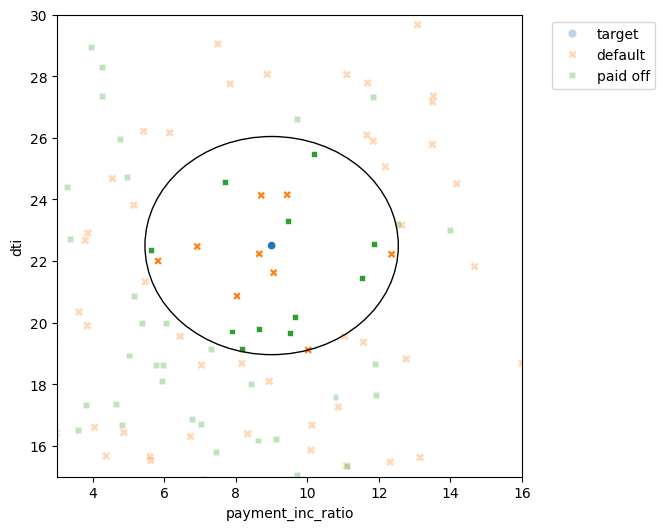

In [8]:
nbrs = knn.kneighbors(newloan)    # Find the k-nearest neighbors for 'newloan' using the trained KNN model
maxDistance = np.max(nbrs[0][0])  # Calculate the maximum distance to the nearest neighbors

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(6, 6))  # Set the size of the plot to be 6x6 inches

# Scatter plot of all loans with 'payment_inc_ratio' on x-axis and 'dti' on y-axis
sns.scatterplot(x='payment_inc_ratio', 
                y='dti', style='outcome',  # Style points by outcome ('default' or 'paid off')
                hue='outcome',             # Color points based on the outcome variable
                data=loan200,              # Use the 'loan200' dataset for this plot
                alpha=0.3, ax=ax)          # Set transparency to 30% to reduce overlapping effects

# Scatter plot for the 'newloan' and its nearest neighbors
sns.scatterplot(x='payment_inc_ratio', y='dti', style='outcome',  # Plot outcome to differentiate 'default' or 'paid off'
                hue='outcome',                                    # Color points based on outcome (same as before)
                data=pd.concat([loan200.loc[0:0, :], loan200.loc[nbrs[1][0] + 1, :]]),  # Plot 'newloan' and its neighbors
                ax=ax, legend=False)                              # Use the same axis and disable additional legend

# Draw an ellipse around 'newloan' to indicate the neighborhood
ellipse = Ellipse(xy=newloan.values[0],    # Set the center of the ellipse at the location of 'newloan'
                  width=2 * maxDistance,   # Set the width of the ellipse to twice the max distance
                  height=2 * maxDistance,  # Set the height of the ellipse to twice the max distance
                  edgecolor='black',       # Set the edge color to black for visibility
                  fc='None',               # No fill color for the ellipse
                  lw=1)                    # Set the line width of the ellipse border to 1

ax.add_patch(ellipse)  # Add the ellipse to the plot

# Set limits for x and y axes to focus the plot area
ax.set_xlim(3, 16)   # Set x-axis limits to range from 3 to 16 for better visualization
ax.set_ylim(15, 30)  # Set y-axis limits to range from 15 to 30 for better visualization

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left') # Add a legend to describe the plot components

plt.show()           # Display the final plot

*KNN prediction of loan default using two variables: debt-to-income ratio and loan-payment-to-income ratio*

The new loan to be predicted is the circle in the middle. The squares (paid off) and cross (default) are the training data.
The large black circle shows the boundary of the nearest 20 points. In this case, 9
defaulted loans lie within the circle, as compared with 11 paid-off loans. Hence the
predicted outcome of the loan is paid off. Note that if we consider only three nearest
neighbors, the prediction would be that the loan defaults.

# Standardization (Normalization, Z-Scores)

For **KNN** and a few other procedures (e.g., **PCA** and **Clustering**), it is essential to consider standardizing the data prior to applying the procedure.

In [13]:
# Load the CSV data into a DataFrame
url2 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan_data.csv')  
loan_data = pd.read_csv(url2)

loan_data.head()

,Unnamed: 0,status,loan_amnt,term,annual_inc,dti,payment_inc_ratio,revol_bal,revol_util,purpose,...,delinq_2yrs_zero,pub_rec_zero,open_acc,grade,outcome,emp_length,purpose_,home_,emp_len_,borrower_score
0,1,Charged Off,2500,60 months,30000,1.00,2.39320,1687,9.4,car,...,1,1,3,4.8,default,1,major_purchase,RENT,> 1 Year,0.65
1,2,Charged Off,5600,60 months,40000,5.55,4.57170,5210,32.6,small_business,...,1,1,11,1.4,default,5,small_business,OWN,> 1 Year,0.80
2,3,Charged Off,5375,60 months,15000,18.08,9.71600,9279,36.5,other,...,1,1,2,6.0,default,1,other,RENT,> 1 Year,0.60
3,4,Charged Off,9000,36 months,30000,10.08,12.21520,10452,91.7,debt_consolidation,...,1,1,4,4.2,default,1,debt_consolidation,RENT,> 1 Year,0.50
4,5,Charged Off,10000,36 months,100000,7.06,3.90888,11997,55.5,other,...,1,1,14,5.4,default,4,other,RENT,> 1 Year,0.55


In [14]:
loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])          # Drop unnecessary columns ('Unnamed: 0' and 'status')

# Convert 'outcome' to a categorical variable with a specific order ('paid off' < 'default')
loan_data['outcome'] = pd.Categorical(loan_data['outcome'],           # Convert 'outcome' column to a categorical type
                                      categories=['paid off', 'default'],  # Define the categories explicitly, setting 'paid off' < 'default'
                                      ordered=True)                   # Specify that the categories are ordered to give them meaningful ranking

# Define predictor variables and outcome variable
predictors = ['payment_inc_ratio', 'dti', 'revol_bal', 'revol_util']  # Features used to predict the outcome
outcome = 'outcome'                                                   # Define the target variable ('paid off' or 'default')

newloan = loan_data.loc[0:0, predictors]                              # Extract the feature values for the first loan (new loan to be predicted)

print(newloan)                                                        # Print the features of the new loan to verify the data
print()

# Split the data into training set (excluding the first row which is 'newloan')
X = loan_data.loc[1:, predictors]                                     # Extract features for the remaining loans to train the model
y = loan_data.loc[1:, outcome]                                        # Extract the outcome variable for the training data

# Initialize and fit K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier(n_neighbors=5)                             # Instantiate KNN model with 5 nearest neighbors
knn.fit(X, y)                                                         # Fit the KNN model to the training data

# Find the nearest neighbors for the new loan
nbrs = knn.kneighbors(newloan)                                        # Get the distances and indices of the nearest neighbors for 'newloan'
print(X.iloc[nbrs[1][0], :])                                          # Print the feature values of the 5 nearest neighbors to 'newloan'

   payment_inc_ratio  dti  revol_bal  revol_util
0             2.3932  1.0       1687         9.4

       payment_inc_ratio   dti  revol_bal  revol_util
35536            1.47212  1.46       1686        10.0
33651            3.38178  6.37       1688         8.4
25863            2.36303  1.39       1691         3.5
42953            1.28160  7.14       1684         3.9
43599            4.12244  8.98       1684         7.2


The value of revol_bal in these neighbors is very close to its value in the new record,
but the other predictor variables are all over the map and essentially play no role in
determining neighbors.

In [16]:
newloan = loan_data.loc[0:0, predictors]       # Extract the feature values for the first loan

X = loan_data.loc[1:, predictors]              # Extract the feature values from the second row onwards
y = loan_data.loc[1:, outcome]                 # Extract the outcome values for the training data

# Standardize the predictor variables
scaler = preprocessing.StandardScaler()        # Instantiate a StandardScaler to standardize the features
scaler.fit(X * 1.0)                            # Fit the scaler to the feature values, converting to float for scaling

# Transform the features to have a mean of 0 and standard deviation of 1
X_std = scaler.transform(X * 1.0)              # Standardize the training data (scale it based on the fitted scaler)
newloan_std = scaler.transform(newloan * 1.0)  # Standardize the new loan data using the same scaler

# Initialize and fit K-Nearest Neighbors (KNN) model using standardized data
knn = KNeighborsClassifier(n_neighbors=5)      # Instantiate KNN model with 5 nearest neighbors
knn.fit(X_std, y)                              # Fit the KNN model to the standardized training data and labels

# Find the nearest neighbors for the standardized new loan
nbrs = knn.kneighbors(newloan_std)             # Get the distances and indices of the nearest neighbors for 'newloan_std'

# Print the feature values of the 5 nearest neighbors (original unstandardized values for interpretation)
print(X.iloc[nbrs[1][0], :])                   # Print the feature values of the nearest neighbors in their original (unstandardized) form

       payment_inc_ratio   dti  revol_bal  revol_util
2080             2.61091  1.03       1218         9.7
1438             2.34343  0.51        278         9.9
30215            2.71200  1.34       1075         8.5
28542            2.39760  0.74       2917         7.4
44737            2.34309  1.37        488         7.2


The five nearest neighbors are much more alike in all the variables, providing a more
sensible result. Note that the results are displayed on the original scale, but KNN was
applied to the scaled data and the new loan to be predicted.

**Normalization (standardization) does not change the distributional shape of the data; it does not make it normally shaped if it was not
already normally shaped.**

# KNN as a Feature Engine

KNN gained its popularity due to its simplicity and intuitive nature. In terms of performance, KNN by itself is usually not competitive with more sophisticated classification techniques. In practical model fitting, however, KNN can be used to add “local knowledge” in a staged process with other classification techniques.

In [21]:
# Data Set

url2 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan_data.csv')  
loan_data = pd.read_csv(url2)

loan_data = loan_data.drop(columns=['Unnamed: 0', 'status'])  # Drop unnecessary columns ('Unnamed: 0' and 'status')

# Convert 'outcome' column to a categorical variable with ordered categories ('paid off' < 'default')
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)

In [22]:
loan_data.shape

(45342, 19)

In [23]:
predictors = ['dti', 'revol_bal', 'revol_util', 'open_acc', 'delinq_2yrs_zero', 'pub_rec_zero']  # Features used for prediction
outcome = 'outcome'                                                                              # Define the target variable ('paid off' or 'default')

X = loan_data[predictors]  # Extract feature values from the dataset for training the model
y = loan_data[outcome]     # Extract outcome variable from the dataset

# Initialize and fit K-Nearest Neighbors (KNN) model
knn = KNeighborsClassifier(n_neighbors=20)  # Instantiate the KNN model with 20 nearest neighbors
knn.fit(X, y)                               # Fit the KNN model to the feature data (X) and labels (y)

# Predict the probability of the 'paid off' outcome for each row in the dataset
knn.predict_proba(X)[:, 0]  # Get the probability of 'paid off' for each observation (first column represents 'paid off')

array([0.35, 0.2 , 0.4 , ..., 0.45, 0.35, 0.5 ])

In [24]:
# Add 'borrower_score' as a new column in the dataset based on predicted probabilities
loan_data['borrower_score'] = knn.predict_proba(X)[:, 0]  # Store the predicted probabilities as a new feature called 'borrower_score'

# Summary statistics for the 'borrower_score' column
loan_data['borrower_score'].describe()

count    45342.000000
mean         0.501091
std          0.128728
min          0.000000
25%          0.400000
50%          0.500000
75%          0.600000
max          0.950000
Name: borrower_score, dtype: float64

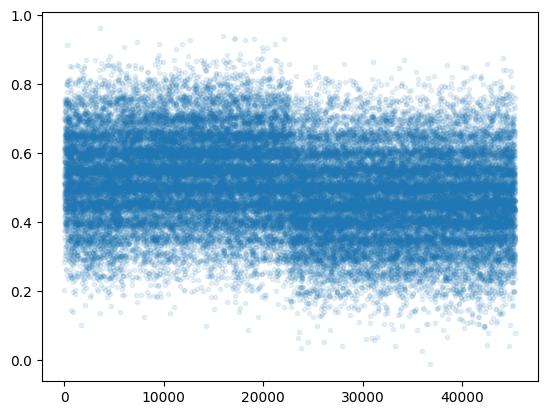

In [25]:
# Create a scatter plot of borrower scores with some added noise for better visibility
plt.scatter(range(len(X)),                                                       # X-axis represents the index of each observation
            [bs + random.gauss(0, 0.015) for bs in knn.predict_proba(X)[:, 0]],  # Y-axis represents borrower scores with small random noise added
            alpha=0.1,                                                           # Set the transparency of the points to 10%
            marker='.');                                                         # Use '.' marker to plot each point

    X-axis: each row from the dataset
    Y-axis: the respective probability for that row be 'paid off'

From the graph, we can observe that the borrower scores are fairly uniformly distributed between 0.2 and 0.8. This implies that the predictions from the KNN model for the likelihood of paid off ('paid off' probability) do not lean heavily toward extreme values (like 0 or 1), but rather are spread more evenly across a central range. The addition of small Gaussian noise helps in visualizing overlapping data points by spreading them out, providing a more detailed look at the density.

# Tree Models
### A Simple Example

In [29]:
# Load the CSV data into a DataFrame
url3 = ('https://raw.githubusercontent.com/arvindbetrabet/Practical_Statistics_for_Data_Scientists/refs/heads/master/data/loan3000.csv')  
loan3000 = pd.read_csv(url3)

loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


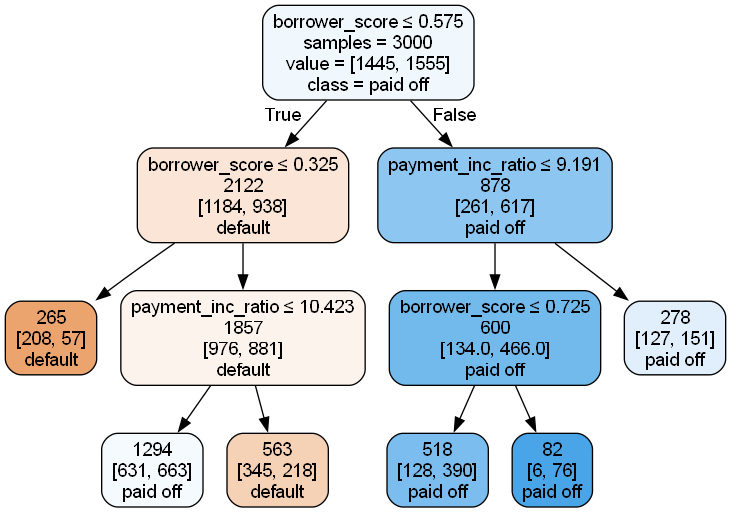

In [30]:
predictors = ['borrower_score', 'payment_inc_ratio']  # Define the predictor variables
outcome = 'outcome'                                   # Define the target variable

X = loan3000[predictors]  # Extract features (borrower score and payment income ratio) from the dataset
y = loan3000[outcome]     # Extract target values (outcome) from the dataset

loan_tree = DecisionTreeClassifier(random_state=1,               # Instantiate the Decision Tree with fixed seed for reproducibility
                                   criterion='entropy',          # Use entropy to measure the quality of splits
                                   min_impurity_decrease=0.003)  # Minimum impurity decrease required to split a node

loan_tree.fit(X, y)       # Fit the Decision Tree model to the feature data and target labels

plotDecisionTree(loan_tree,                       # Plot the decision tree to visualize its structure
                 feature_names=predictors,        # Use predictor names as feature names in the plot
                 class_names=loan_tree.classes_)  # Use target class names in the plot

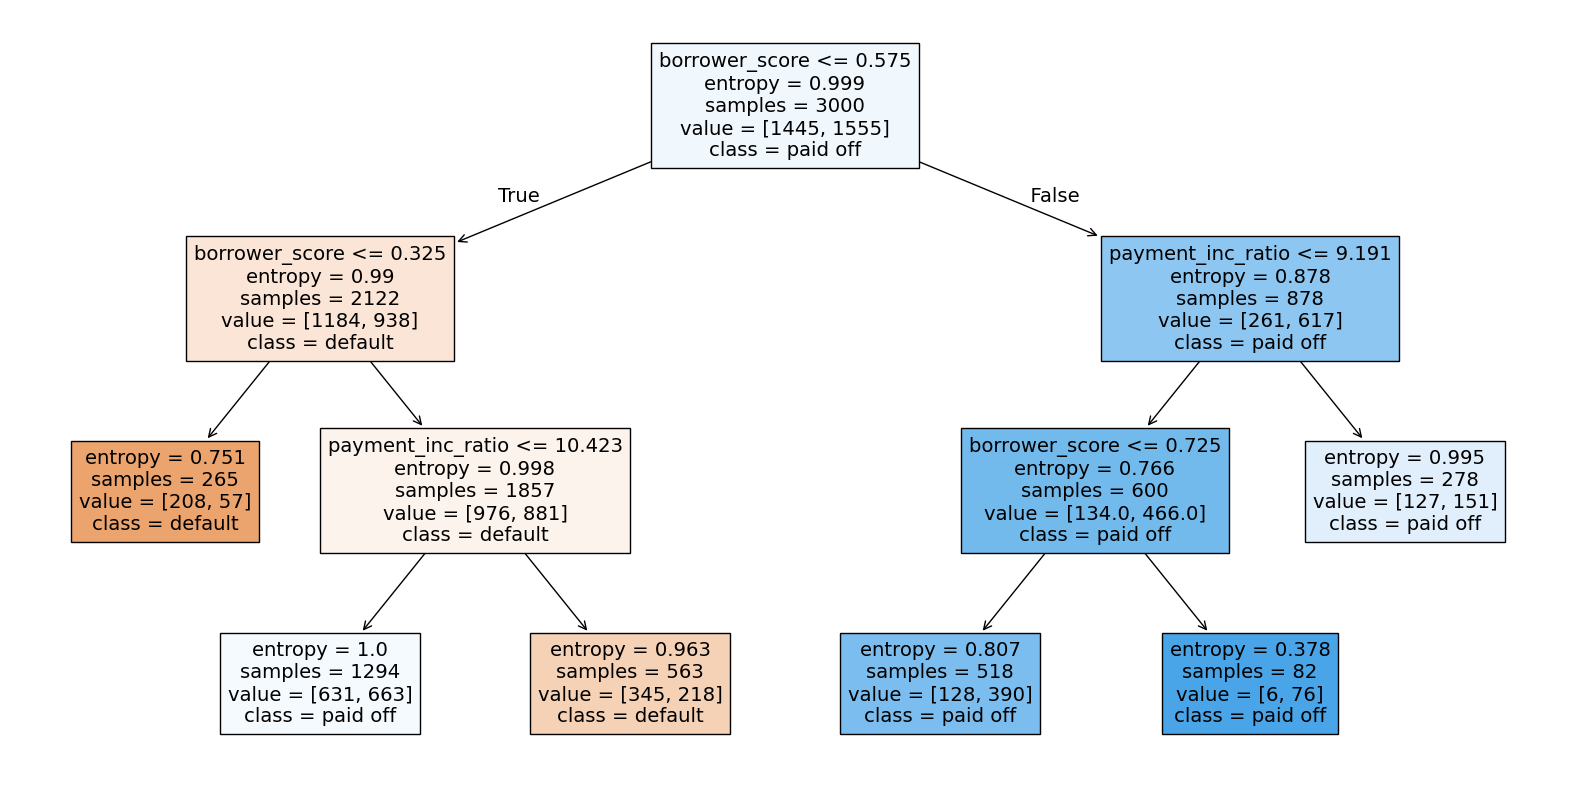

In [31]:
# Alternative plot

from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))               # Set the figure size for better visualization of the decision tree

plot_tree(loan_tree,                       # Plot the decision tree model
          feature_names=predictors,        # Use feature names ('borrower_score' and 'payment_inc_ratio') in the plot
          class_names=loan_tree.classes_,  # Use class names ('paid off' and 'default') in the plot
          filled=True)                     # Color nodes by class label for better differentiation

plt.show()                                 # Display the decision tree plot

In [32]:
print(textDecisionTree(loan_tree))

node=0 test node: go to node 1 if 0 <= 0.5750000178813934 else to node 6
  node=1 test node: go to node 2 if 0 <= 0.32500000298023224 else to node 3
    node=2 leaf node: [[0.785, 0.215]]
    node=3 test node: go to node 4 if 1 <= 10.42264986038208 else to node 5
      node=4 leaf node: [[0.488, 0.512]]
      node=5 leaf node: [[0.613, 0.387]]
  node=6 test node: go to node 7 if 1 <= 9.19082498550415 else to node 10
    node=7 test node: go to node 8 if 0 <= 0.7249999940395355 else to node 9
      node=8 leaf node: [[0.247, 0.753]]
      node=9 leaf node: [[0.073, 0.927]]
    node=10 leaf node: [[0.457, 0.543]]


# The Recursive Partitioning Algorithm
The algorithm to construct a decision tree, called recursive partitioning, is straightforward and intuitive. The data is repeatedly partitioned using predictor values that do
the best job of separating the data into relatively homogeneous partitions.

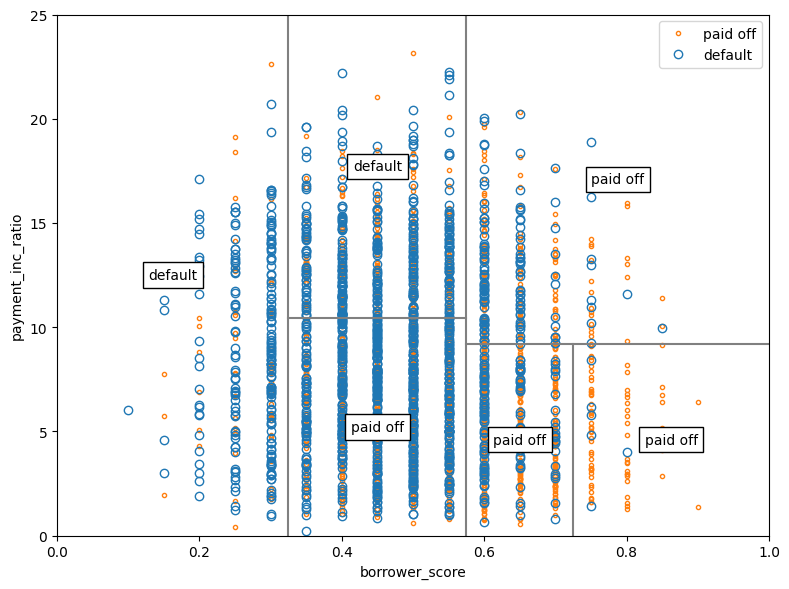

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))  # Create a figure and axis

# Plot points for 'paid off' loans using borrower_score vs payment_inc_ratio
loan3000.loc[loan3000.outcome == 'paid off'].plot(
    x='borrower_score',      # X-axis is 'borrower_score'
    y='payment_inc_ratio',   # Y-axis is 'payment_inc_ratio'
    style='.',               # Use a dot marker style
    markerfacecolor='none',  # Set marker face color to none
    markeredgecolor='C1',    # Set marker edge color to 'C1' (second color in the color cycle)
    ax=ax)                   # Plot on the same axis

# Plot points for 'default' loans using borrower_score vs payment_inc_ratio
loan3000.loc[loan3000.outcome == 'default'].plot(
    x='borrower_score',      # X-axis is 'borrower_score'
    y='payment_inc_ratio',   # Y-axis is 'payment_inc_ratio'
    style='o',               # Use a circle marker style
    markerfacecolor='none',  # Set marker face color to none
    markeredgecolor='C0',    # Set marker edge color to 'C0' (first color in the color cycle)
    ax=ax)                   # Plot on the same axis

# Set legend labels for the plot
ax.legend(['paid off', 'default'])  # Set the legend to display categories: 'paid off' and 'default'

# Set axis limits for better visualization
ax.set_xlim(0, 1)            # Limit the x-axis values between 0 and 1
ax.set_ylim(0, 25)           # Limit the y-axis values between 0 and 25

# Set axis labels
ax.set_xlabel('borrower_score')     # Set the x-axis label
ax.set_ylabel('payment_inc_ratio')  # Set the y-axis label

# Define decision boundary lines and draw them on the plot
x0 = 0.575                 # Define vertical boundary line at x = 0.575
x1a = 0.325; y1b = 9.191   # Define another vertical boundary at x = 0.325, and horizontal boundary at y = 9.191
y2a = 10.423; x2b = 0.725  # Define another set of boundaries: horizontal at y = 10.423 and vertical at x = 0.725

# Plot decision boundaries based on the defined points
ax.plot((x0, x0), (0, 25), color='grey')      # Vertical line from (x0, 0) to (x0, 25)
ax.plot((x1a, x1a), (0, 25), color='grey')    # Vertical line from (x1a, 0) to (x1a, 25)
ax.plot((x0, 1), (y1b, y1b), color='grey')    # Horizontal line from (x0, y1b) to (1, y1b)
ax.plot((x1a, x0), (y2a, y2a), color='grey')  # Horizontal line from (x1a, y2a) to (x0, y2a)
ax.plot((x2b, x2b), (0, y1b), color='grey')   # Vertical line from (x2b, 0) to (x2b, y1b)

# Define label positions and corresponding labels for each region
labels = [
    ('default', (x1a / 2, 25 / 2)),                 # Label 'default' in leftmost region
    ('default', ((x0 + x1a) / 2, (25 + y2a) / 2)),  # Label 'default' in next region
    ('paid off', ((x0 + x1a) / 2, y2a / 2)),        # Label 'paid off' below the boundary line
    ('paid off', ((1 + x0) / 2, (y1b + 25) / 2)),   # Label 'paid off' in the top right region
    ('paid off', ((1 + x2b) / 2, (y1b + 0) / 2)),   # Label 'paid off' in the bottom right region
    ('paid off', ((x0 + x2b) / 2, (y1b + 0) / 2)),  # Label 'paid off' in the center region
]

# Add text labels to the plot for each region
for label, (x, y) in labels:
    ax.text(x, y, label, bbox={'facecolor': 'white'},                  # Add text with white box background
            verticalalignment='center', horizontalalignment='center')  # Center text horizontally and vertically

plt.tight_layout()  # Adjust the plot layout for better fit
plt.show()          # Display the plot

The first rule, depicted by rule 1, is `borrower_score >= 0.575` and segments the right portion of the plot. 

The second rule is `borrower_score < 0.375` and segments the left portion.

# Measuring Homogeneity or Impurity

It turns out that accuracy is not a good measure for impurity. Instead, two common measures for impurity are the Gini impurity and entropy of information. While these (and other) impurity measures apply to classification problems with more than two classes, we focus on the binary case. 

The Gini impurity for a set of records A is:

    I(A) = p(1 − p)

The entropy measure is given by:

    I(A) = − plog2 (p) − (1 − p)log2 (1 − p)

In [38]:
# Define the entropy function to calculate binary entropy
def entropyFunction(x):             
    if x == 0: return 0         # Return 0 if x is 0 (to avoid log(0) calculation)
    return -x * math.log(x, 2) - (1 - x) * math.log(1 - x, 2)  # Calculate entropy using binary log formula

# Define the Gini function to calculate Gini impurity
def giniFunction(x):                
    return x * (1 - x)          # Calculate Gini impurity for binary classification

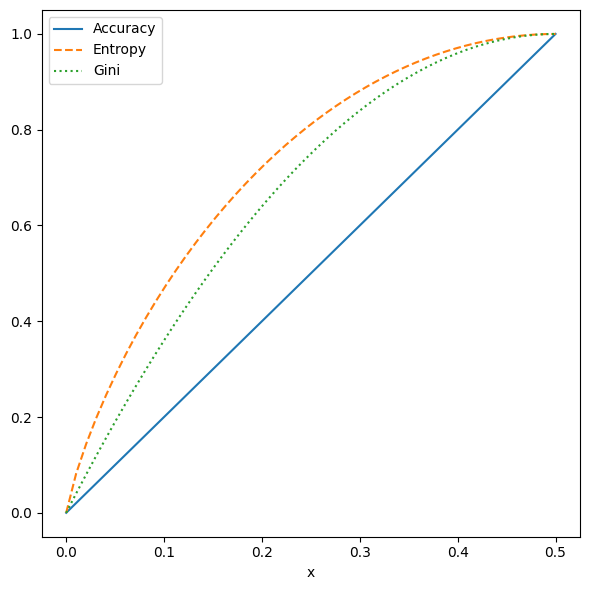

In [39]:
x = np.linspace(0, 0.5, 50)             # Create an array of 50 evenly spaced values between 0 and 0.5

# Create a DataFrame to store impurity measures for plotting
impure = pd.DataFrame({
    'x': x,                                                      # Values for the x-axis
    'Accuracy': 2 * x,                                           # Accuracy represented by 2 * x
    'Gini': [giniFunction(xi) / giniFunction(0.5) for xi in x],  # Normalized Gini impurity values
    'Entropy': [entropyFunction(xi) for xi in x],                # Entropy values for each x
})

fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis with size 4x4 inches for plotting

# Plot the 'Accuracy', 'Entropy', and 'Gini' columns from the DataFrame
impure.plot(x='x', y='Accuracy', ax=ax, linestyle='solid')       # Plot 'Accuracy' with a solid line
impure.plot(x='x', y='Entropy', ax=ax, linestyle='--')           # Plot 'Entropy' with a dashed line
impure.plot(x='x', y='Gini', ax=ax, linestyle=':')               # Plot 'Gini' with a dotted line

plt.tight_layout()  # Automatically adjust subplot parameters for better layout
plt.show()          # Display the plot

*The graphic shows that Gini impurity (rescaled) and entropy measures are similar, with entropy giving higher impurity scores for moderate and high accuracy rates.*

# Bagging and the Random Forest
## Random Forest

In [42]:
predictors = ['borrower_score', 'payment_inc_ratio']  # Define predictors (features)
outcome = 'outcome'                                   # Define target variable

X = loan3000[predictors]  # Extract feature values from dataset
y = loan3000[outcome]     # Extract outcome variable from dataset

# Instantiate a Random Forest model with 500 trees and enable out-of-bag (OOB) scoring
rf = RandomForestClassifier(n_estimators=500,  # Number of trees in the forest
                            random_state=1,    # Random seed for reproducibility
                            oob_score=True)    # Enable OOB samples to estimate model accuracy

rf.fit(X, y)  # Fit the model to the data

print(rf.oob_decision_function_)  # Print the OOB decision function probabilities

[[0.18131868 0.81868132]
 [0.26704545 0.73295455]
 [0.93333333 0.06666667]
 ...
 [1.         0.        ]
 [0.73157895 0.26842105]
 [0.68085106 0.31914894]]


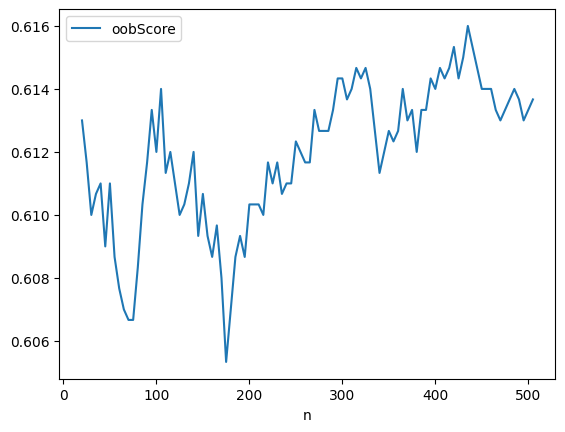

In [43]:
n_estimator = list(range(20, 510, 5))  # Generate a list of n_estimators from 20 to 505 with a step of 5

oobScores = []                         # Initialize an empty list to store out-of-bag scores

# Loop through different n_estimators to evaluate Random Forest performance:
for n in n_estimator:                                 # Iterate over each value in n_estimator list
    rf = RandomForestClassifier(n_estimators=n,       # Instantiate Random Forest with n trees
                                criterion='entropy',  # Use 'entropy' as the criterion for splitting
                                max_depth=5,          # Set maximum depth of each tree to 5
                                random_state=1,       # Use a fixed seed for reproducibility
                                oob_score=True)       # Enable out-of-bag score estimation
    rf.fit(X, y)                                      # Fit the model to the data
    oobScores.append(rf.oob_score_)                   # Append the out-of-bag score to the oobScores list

# Create a DataFrame with n_estimator values and their corresponding out-of-bag scores
pd.DataFrame({
    'n': n_estimator,         # Number of trees (n_estimators)
    'oobScore': oobScores     # Out-of-bag scores for each value of n_estimators
}).plot(x='n', y='oobScore')  # Plot the out-of-bag score against the number of trees

plt.show();                   # Display the plot

Explanation:

    X-axis (n): The number of trees in the Random Forest (n_estimators).
    Y-axis (oobScore): The out-of-bag score, which is an unbiased estimate of the model's accuracy.

The best choice for n_estimators is around 400 to 450. This range provides the highest OOB score and relatively stable performance, indicating that the Random Forest model is making better predictions with more trees without overfitting.

An Out-of-Bag (OOB) score of 0.614 means that the Random Forest model correctly predicts the outcome for 61.4% of the OOB samples during training. The model still misclassifies a significant portion of the data (about 38.6%).

The OOB score is similar to accuracy in a cross-validation scenario. It's calculated using data that the individual trees have not seen during training, so it's a good proxy for model performance on unseen data. However, the OOB score is not the only metric to evaluate a Random Forest model. Depending on the specific problem (e.g., classification vs. regression, imbalanced classes), other metrics like precision, recall, F1-score, AUC, or confusion matrix could provide a more detailed evaluation.

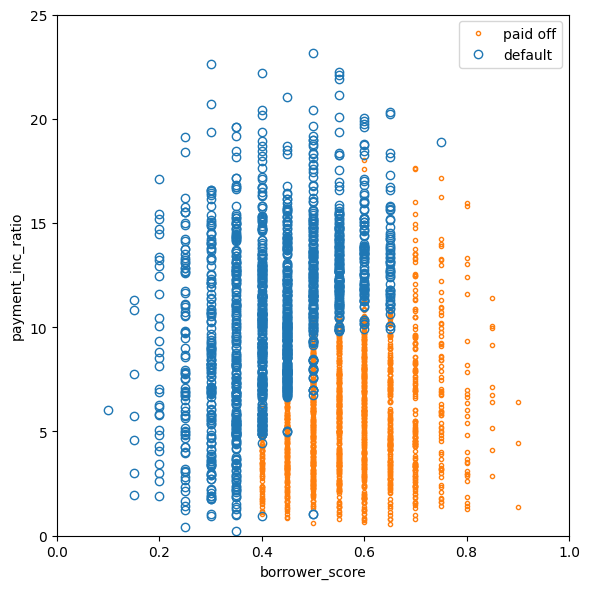

In [47]:
predictions = X.copy()                               # Create a copy of the feature DataFrame to store predictions
predictions['prediction'] = rf.predict(X)            # Add a new column called 'prediction' with model predictions
predictions.head()                                   # Display the first 5 rows of the updated DataFrame

fig, ax = plt.subplots(figsize=(6, 6))               # Create a figure and axis with dimensions 6x6 inches

# Plot borrower_score vs. payment_inc_ratio for observations predicted as 'paid off'
predictions.loc[predictions.prediction=='paid off'].plot(
    x='borrower_score',                              # Set x-axis to 'borrower_score'
    y='payment_inc_ratio',                           # Set y-axis to 'payment_inc_ratio'
    style='.',                                       # Use '.' to represent each point on the scatter plot
    markerfacecolor='none',                          # No fill color for marker
    markeredgecolor='C1',                            # Set edge color of marker to 'C1' (a predefined color)
    ax=ax)                                           # Plot on the same axis

# Plot borrower_score vs. payment_inc_ratio for observations predicted as 'default'
predictions.loc[predictions.prediction=='default'].plot(
    x='borrower_score',                              # Set x-axis to 'borrower_score'
    y='payment_inc_ratio',                           # Set y-axis to 'payment_inc_ratio'
    style='o',                                       # Use 'o' to represent each point on the scatter plot
    markerfacecolor='none',                          # No fill color for marker
    markeredgecolor='C0',                            # Set edge color of marker to 'C0' (another predefined color)
    ax=ax)                                           # Plot on the same axis

ax.legend(['paid off', 'default'])                   # Add a legend to differentiate 'paid off' and 'default'
ax.set_xlim(0, 1)                                    # Set x-axis limits between 0 and 1
ax.set_ylim(0, 25)                                   # Set y-axis limits between 0 and 25
ax.set_xlabel('borrower_score')                      # Set x-axis label as 'borrower_score'
ax.set_ylabel('payment_inc_ratio')                   # Set y-axis label as 'payment_inc_ratio'

plt.tight_layout()                                   # Adjust layout to ensure that labels and elements are well fitted
plt.show()                                           # Display the plot

## Variable importance

In [49]:
# Define predictors (features) and outcome variable
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti',                  # List of features used for training the model
              'payment_inc_ratio', 'revol_bal', 'revol_util',            
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero',            
              'open_acc', 'grade', 'emp_length', 'purpose_',            
              'home_', 'emp_len_', 'borrower_score']                    
outcome = 'outcome'                                                      # Define the outcome variable ('paid off' or 'default')

# Create dummy variables for categorical predictors
X = pd.get_dummies(loan_data[predictors],                                # Convert categorical variables into dummy variables
                   drop_first=True,                                      # Drop the first category to avoid multicollinearity
                   dtype=int)                                            # Use integer type for efficiency

# Extract the outcome variable from the dataset
y = loan_data[outcome]                                                   # Assign outcome values from the dataset

# Initialize and fit a Random Forest Classifier using 500 trees
rf_all = RandomForestClassifier(n_estimators=500,                        # Create a Random Forest model with 500 estimators (trees)
                                random_state=1)                          # Set random seed for reproducibility

rf_all.fit(X, y)                                                         # Fit the model to the features (X) and target (y)

RandomForestClassifier(n_estimators=500, random_state=1)

`rf_all`: Random Forest with Gini Index (default criterion)

* **Criterion**: This model uses the *Gini index* for splitting nodes, which is the default behavior for RandomForestClassifier.

* *Gini Index* is a measure of impurity, representing how often a randomly chosen element would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.

* The goal of using the Gini index is to create splits that produce the **least impurity**.

* **Usage**: The Gini index is generally faster to compute and is the default for Random Forest classifiers. It tries to maximize the "purity" of nodes after each split, resulting in **more homogeneous branches**.

In [51]:
# Initialize and fit a Random Forest Classifier using entropy as criterion
rf_all_entropy = RandomForestClassifier(n_estimators=500,                # Create a Random Forest model with 500 estimators (trees)
                                        random_state=1,                  # Set random seed for reproducibility
                                        criterion='entropy')             # Use 'entropy' for calculating splits instead of 'gini' index

print(rf_all_entropy.fit(X, y))                                          # Fit the model to the features (X) and target (y), then print the model

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=1)


`rf_all_entropy`: Random Forest with Entropy (Information Gain)

* **Criterion**: This model uses *entropy* as the criterion for splitting nodes, which is also known as Information Gain.

* *Entropy* measures the uncertainty or impurity in the data. It is used to calculate Information Gain, which represents the reduction in entropy achieved by a split.
  
* The higher the reduction in entropy, the better the split. Therefore, splits are chosen that **maximize Information Gain**.
  
* **Usage**: The entropy criterion is more computationally expensive compared to the Gini index because it involves calculating logarithms, but it is more theoretically aligned with maximizing the amount of information gained with each split.

In [53]:
rf = RandomForestClassifier(n_estimators=500)                         # Initialize a Random Forest classifier with 500 trees

scores = defaultdict(list)                                            # Use a defaultdict to store scores for each feature

# Cross-validate the scores on a number of different random splits of the data
for _ in range(3):                                                    # Repeat for 3 random splits of the data
    train_X, valid_X, train_y, valid_y = train_test_split(X, y,       # Split the dataset into training and validation sets
                                                          test_size=0.3)  # Set aside 30% of the data for validation
    rf.fit(train_X, train_y)                                          # Fit the Random Forest model on the training data
    acc = metrics.accuracy_score(valid_y, rf.predict(valid_X))        # Calculate accuracy on the validation data
    for column in X.columns:                                          # Iterate over each feature in the dataset
        X_t = valid_X.copy()                                          # Make a copy of the validation data
        X_t[column] = np.random.permutation(X_t[column].values)       # Randomly shuffle the values in the current feature column
        shuff_acc = metrics.accuracy_score(valid_y, rf.predict(X_t))  # Calculate accuracy with the shuffled feature column
        scores[column].append((acc - shuff_acc) / acc)                # Compute the feature importance as the change in accuracy

# Print features sorted by their average score
print('Features sorted by their score:')                              # Print message indicating feature importance sorting
print(sorted([(round(np.mean(score), 4), feat) for                    # Calculate the average importance score for each feature
              feat, score in scores.items()], reverse=True))          # Sort the features by score in descending order

Features sorted by their score:
[(0.0767, 'borrower_score'), (0.0397, 'grade'), (0.0258, 'term_60 months'), (0.0146, 'annual_inc'), (0.0099, 'payment_inc_ratio'), (0.0043, 'dti'), (0.0026, 'emp_length'), (0.0025, 'revol_util'), (0.0024, 'open_acc'), (0.0019, 'purpose__small_business'), (0.0013, 'home__OWN'), (0.0012, 'purpose_small_business'), (0.001, 'revol_bal'), (0.001, 'home__RENT'), (0.0007, 'pub_rec_zero'), (0.0004, 'purpose__major_purchase'), (0.0003, 'purpose_home_improvement'), (0.0003, 'purpose__other'), (0.0003, 'emp_len__ > 1 Year'), (0.0002, 'delinq_2yrs_zero'), (0.0001, 'purpose_wedding'), (0.0001, 'purpose_moving'), (0.0, 'purpose_other'), (-0.0, 'purpose_medical'), (0.0, 'purpose__medical'), (-0.0001, 'purpose_vacation'), (-0.0001, 'purpose_house'), (-0.0002, 'purpose_debt_consolidation'), (-0.0002, 'purpose_credit_card'), (-0.0004, 'purpose_major_purchase'), (-0.0004, 'purpose__home_improvement'), (-0.0005, 'purpose__debt_consolidation'), (-0.0008, 'loan_amnt')]


In [54]:
# For better visualization:

measures = sorted([(round(np.mean(score), 4), feat) for             # Calculate the average importance score for each feature
              feat, score in scores.items()], reverse=True)         # Sort the features by score in descending order
measures

[(0.0767, 'borrower_score'),
 (0.0397, 'grade'),
 (0.0258, 'term_60 months'),
 (0.0146, 'annual_inc'),
 (0.0099, 'payment_inc_ratio'),
 (0.0043, 'dti'),
 (0.0026, 'emp_length'),
 (0.0025, 'revol_util'),
 (0.0024, 'open_acc'),
 (0.0019, 'purpose__small_business'),
 (0.0013, 'home__OWN'),
 (0.0012, 'purpose_small_business'),
 (0.001, 'revol_bal'),
 (0.001, 'home__RENT'),
 (0.0007, 'pub_rec_zero'),
 (0.0004, 'purpose__major_purchase'),
 (0.0003, 'purpose_home_improvement'),
 (0.0003, 'purpose__other'),
 (0.0003, 'emp_len__ > 1 Year'),
 (0.0002, 'delinq_2yrs_zero'),
 (0.0001, 'purpose_wedding'),
 (0.0001, 'purpose_moving'),
 (0.0, 'purpose_other'),
 (-0.0, 'purpose_medical'),
 (0.0, 'purpose__medical'),
 (-0.0001, 'purpose_vacation'),
 (-0.0001, 'purpose_house'),
 (-0.0002, 'purpose_debt_consolidation'),
 (-0.0002, 'purpose_credit_card'),
 (-0.0004, 'purpose_major_purchase'),
 (-0.0004, 'purpose__home_improvement'),
 (-0.0005, 'purpose__debt_consolidation'),
 (-0.0008, 'loan_amnt')]

This is the importance of each feature and its impact on model accuracy.

    (importance_score, feature_name)

'borrower_score' has the highest score of 0.0761, indicating that shuffling this feature significantly decreases the model's accuracy. Thus, it is the most important feature for predicting the outcome.

'loan_amnt' and many others near the bottom have scores close to 0 or even negative values. This implies that these features have minimal impact on the model's accuracy or, in some cases, their inclusion might even slightly worsen the performance.

A *negative score* means that shuffling the feature slightly improves the model accuracy. It suggests that the feature *might not* be adding relevant information or may even be adding some noise that confuses the model.

**We could consider removing features with scores near 0 or negative values, as they don't add much predictive power and may reduce model complexity, leading to a simpler, potentially more interpretable model.**

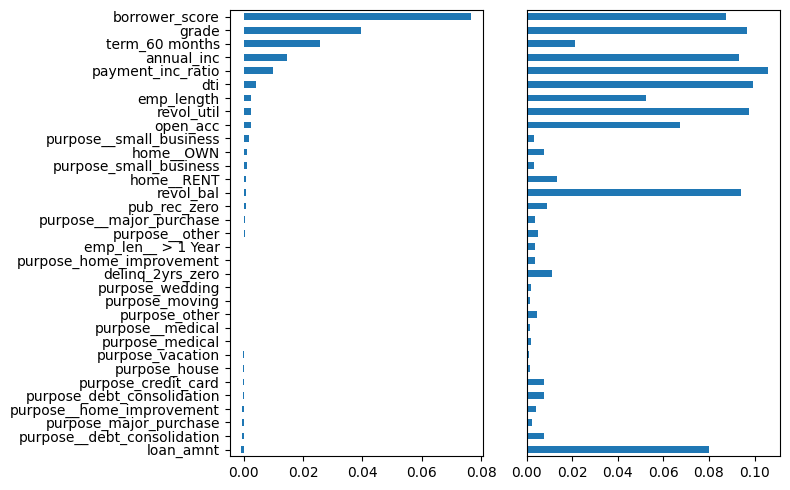

In [56]:
importances = rf_all.feature_importances_                               # Get the feature importances from the trained Random Forest model

df = pd.DataFrame({                                                     # Create a DataFrame to summarize feature importances
    'feature': X.columns,                                               # Feature names
    'Accuracy decrease': [np.mean(scores[column]) for column in         # Average decrease in accuracy for each feature from shuffling
                         X.columns],
    'Gini decrease': rf_all.feature_importances_,                       # Feature importance as measured by Gini (Random Forest with Gini)
    'Entropy decrease': rf_all_entropy.feature_importances_,            # Feature importance as measured by entropy (Random Forest with entropy)
})

df = df.sort_values('Accuracy decrease')                                # Sort the DataFrame by 'Accuracy decrease' in ascending order

# Create a figure with two side-by-side subplots
fig, axes = plt.subplots(ncols=2, figsize=(8, 5))                       # Create subplots for visualizing feature importances

# Plot bar chart for 'Accuracy decrease' feature importance
ax = df.plot(kind='barh',                                               # Horizontal bar chart to show feature importance
             x='feature',                                               # Use 'feature' column as x-axis
             y='Accuracy decrease',                                     # Plot 'Accuracy decrease' values
             legend=False,                                              # Do not show legend
             ax=axes[0])                                                # Use the first subplot axis
ax.set_ylabel('')                                                       # Remove y-axis label to keep it clean

# Plot bar chart for 'Gini decrease' feature importance
ax = df.plot(kind='barh',                                               # Horizontal bar chart to show Gini-based feature importance
             x='feature',                                               # Use 'feature' column as x-axis
             y='Gini decrease',                                         # Plot 'Gini decrease' values
             legend=False,                                              # Do not show legend
             ax=axes[1])                                                # Use the second subplot axis
ax.set_ylabel('')                                                       # Remove y-axis label for the second subplot
ax.get_yaxis().set_visible(False)                                       # Hide y-axis labels in the second subplot to avoid redundancy

plt.tight_layout()                                                      # Adjust layout to ensure no overlap between elements
plt.show()                                                              # Display the figure with both subplots

Feature importance based on different metrics:

* Left Chart ("Accuracy Decrease"):
  
This chart displays the importance of features as measured by the decrease in accuracy when each feature is randomly shuffled.
If shuffling a feature causes a large drop in accuracy, it means the feature is important for predicting the target variable ('outcome').
Features are sorted from least important (top) to most important (bottom) based on accuracy decrease.

* Right Chart ("Gini Decrease"):
  
This chart shows feature importance as measured by the Gini impurity reduction in the Random Forest model.
Gini impurity is used in Random Forests to measure the quality of a split when training decision trees. If a feature is important, it will be used more often for splits that reduce impurity in the data.
The chart shows which features have contributed the most to reducing impurity and thus are more important for the decision-making process of the model.

In this graph, 'borrower_score' has the highest accuracy decrease, indicating that it is the most crucial feature for predicting whether a loan will be 'paid off' or in 'default'.

Features like 'grade', 'term_60 months', 'borrower_score', and 'annual_inc' are shown to have high importance as they contribute significantly to reducing impurity in the decision trees.

**Compared to accuracy decrease, there are some differences in the ranking, reflecting the fact that different metrics can sometimes rank feature importance differently.**

* The features that consistently appear as high importance in both metrics ('borrower_score', 'grade', 'term_60 months', etc.) are the most valuable features for the model.

* Some features, such as 'purpose_wedding' or 'purpose_house', have little to no contribution to both accuracy and Gini importance, suggesting they might be redundant or uninformative for predicting the target.

* We might consider removing features with very low importance to reduce computational complexity and possibly enhance the interpretability of your model.

# Boosting
## XGBoost

In [60]:
loan3000.head()

,Unnamed: 0,outcome,purpose_,dti,borrower_score,payment_inc_ratio
0,32109,paid off,debt_consolidation,21.23,0.40,5.11135
1,16982,default,credit_card,15.49,0.40,5.43165
2,25335,paid off,debt_consolidation,27.30,0.70,9.23003
3,34580,paid off,major_purchase,21.11,0.40,2.33482
4,14424,default,debt_consolidation,16.46,0.45,12.10320


In [61]:
predictors = ['borrower_score', 'payment_inc_ratio']   # Define the predictor variables (features)
outcome = 'outcome'                                    # Define the target variable ('outcome')

X = loan3000[predictors]                               # Extract feature values from the dataset for training the model
y = pd.Series([1 if o == 'default' else 0 for o in     # Encode 'outcome' as 1 for 'default' and 0 otherwise
               loan3000[outcome]])

# Initialize an XGBoost Classifier for binary classification with specified parameters
xgb = XGBClassifier(objective='binary:logistic',       # Set objective to binary logistic regression
                    subsample=0.63,                    # Use 63% of the data for each boosting round (similar to bootstrapping)
                    eval_metric='error')               # Use 'error' as the evaluation metric

print(xgb.fit(X, y))                                   # Fit the XGBoost model to the feature set (X) and target variable (y) and print the fitted model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [62]:
xgb_df = X.copy()                                            # Create a copy of the feature DataFrame (X)

# Add a column with the predicted class ('default' or 'paid off') for each observation
xgb_df['prediction'] = ['default' if p == 1 else 'paid off'  # Use list comprehension to assign 'default' if prediction is 1, else 'paid off'
                        for p in xgb.predict(X)]

# Add a column with the predicted probability of the 'default' class
xgb_df['prob_default'] = xgb.predict_proba(X)[:, 1]          # Extract the predicted probability for the 'default' class (first column)

print(xgb_df.head())                                         # Print the first 5 rows of the modified DataFrame

   borrower_score  payment_inc_ratio prediction  prob_default
0            0.40            5.11135   paid off      0.178502
1            0.40            5.43165    default      0.677598
2            0.70            9.23003    default      0.660398
3            0.40            2.33482   paid off      0.179704
4            0.45           12.10320    default      0.955606


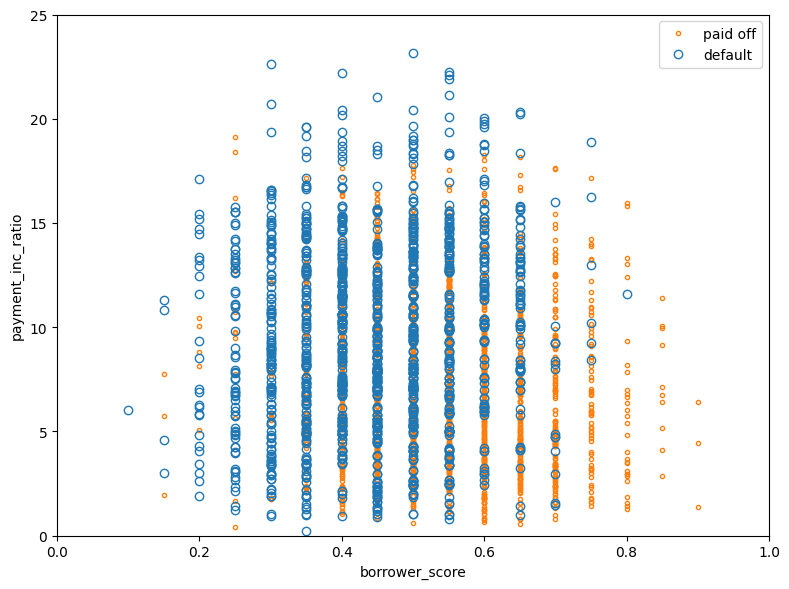

In [63]:
# Create a figure and axis for plotting the scatter plot of borrower_score vs. payment_inc_ratio
fig, ax = plt.subplots(figsize=(8, 6))            # Create a figure of size 8x6 inches

# Plot the data points for loans predicted to be 'paid off'
xgb_df.loc[xgb_df.prediction == 'paid off'].plot( # Filter data for rows with 'paid off' predictions
    x='borrower_score',                           # X-axis represents borrower_score
    y='payment_inc_ratio',                        # Y-axis represents payment_inc_ratio
    style='.',                                    # Use '.' as marker style (small circle)
    markerfacecolor='none',                       # No face color for the markers
    markeredgecolor='C1',                         # Use 'C1' color for the marker edges (typically orange)
    ax=ax                                         # Plot on the defined axis 'ax'
)

# Plot the data points for loans predicted to be 'default'
xgb_df.loc[xgb_df.prediction == 'default'].plot(  # Filter data for rows with 'default' predictions
    x='borrower_score',                           # X-axis represents borrower_score
    y='payment_inc_ratio',                        # Y-axis represents payment_inc_ratio
    style='o',                                    # Use 'o' as marker style (circle)
    markerfacecolor='none',                       # No face color for the markers
    markeredgecolor='C0',                         # Use 'C0' color for the marker edges (typically blue)
    ax=ax                                         # Plot on the same axis 'ax'
)

# Set the legend to label the different predicted outcomes
ax.legend(['paid off', 'default'])                # Add a legend to indicate which color represents each prediction
ax.set_xlim(0, 1)                                 # Set the limit for X-axis (borrower_score) between 0 and 1
ax.set_ylim(0, 25)                                # Set the limit for Y-axis (payment_inc_ratio) between 0 and 25
ax.set_xlabel('borrower_score')                   # Label for X-axis
ax.set_ylabel('payment_inc_ratio')                # Label for Y-axis

# Adjust layout to prevent overlap of plot elements and improve spacing
plt.tight_layout()                                # Make sure subplots fit nicely within the figure area
plt.show()                                        # Display the plot

### Overfitting

Blind application of xgboost can lead to unstable models as a result of *overfitting* to
the training data. The problem with overfitting is twofold:

• The accuracy of the model on new data not in the training set will be degraded.

• The predictions from the model are highly variable, leading to unstable results.

Any modeling technique is potentially prone to overfitting. For example, if too many
variables are included in a regression equation, the model may end up with spurious
predictions. However, for most statistical techniques, overfitting can be avoided by a
judicious selection of predictor variables. Even the random forest generally produces
a reasonable model without tuning the parameters. This, however, is not the case for xgboost.

In [66]:
# Define predictor variables (features) and target variable (outcome)
predictors = ['loan_amnt', 'term', 'annual_inc', 'dti',                 # Predictors such as loan amount, term, annual income, etc.
              'payment_inc_ratio', 'revol_bal', 'revol_util',           
              'purpose', 'delinq_2yrs_zero', 'pub_rec_zero',            
              'open_acc', 'grade', 'emp_length', 'purpose_',            
              'home_', 'emp_len_', 'borrower_score']                    
outcome = 'outcome'                                                     # Define the target variable (outcome) to predict

# Create feature matrix using one-hot encoding for categorical features
X = pd.get_dummies(loan_data[predictors], drop_first=True, dtype=int)   # One-hot encode categorical variables (drop the first category)

# Convert target variable to binary (1 for 'default', 0 for 'paid off')
y = pd.Series([1 if o == 'default' else 0 for o in loan_data[outcome]]) # Convert outcome column to binary labels: 1 for 'default', 0 for 'paid off'

# Split the dataset into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y,             # Split the data into training and validation sets
                                                      test_size=10000)  # Set the validation set size to 10,000 observations

# Initialize the XGBoost classifier with specific hyperparameters
xgb_default = XGBClassifier(objective='binary:logistic',                # Use logistic regression as the objective for binary classification
                            n_estimators=250,                           # Use 250 boosting rounds (number of trees)
                            max_depth=6,                                # Set maximum tree depth to 6
                            reg_lambda=0,                               # Set L2 regularization (lambda) to 0 (no regularization)
                            learning_rate=0.3,                          # Set the learning rate to 0.3
                            subsample=1,                                # Use 100% of data for each boosting round
                            eval_metric='error')                        # Use 'error' as the evaluation metric (classification error)

# Fit the XGBoost model to the training data
xgb_default.fit(train_X, train_y)                                       # Train the XGBoost classifier using the training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [67]:
# Initialize the XGBoost classifier with specific hyperparameters (with penalty)
xgb_penalty = XGBClassifier(objective='binary:logistic',    # Use logistic regression as the objective for binary classification
                            n_estimators=250,               # Use 250 boosting rounds (number of trees)
                            max_depth=6,                    # Set the maximum tree depth to 6 to prevent overfitting
                            reg_lambda=1000,                # Apply L2 regularization (lambda) of 1000 to penalize model complexity
                            learning_rate=0.1,              # Set the learning rate to 0.1 to control how much each tree influences the model
                            subsample=0.63,                 # Use 63% of the data for each boosting round, to add randomness and prevent overfitting
                            eval_metric='error')            # Use 'error' as the evaluation metric (classification error)

# Fit the XGBoost model to the training data
xgb_penalty.fit(train_X, train_y)                           # Train the XGBoost classifier using the training data

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In this code, a high penalty (`reg_lambda=1000`) has been applied, which may reduce model complexity and help prevent overfitting. Moreover, `subsample=0.63` ensures that only a subset of data is used in each boosting round, which also contributes to reducing overfitting and improving generalization performance. The learning rate is lower at `0.1`, which is often recommended when adding regularization or reducing `subsample` as it makes the model update more gradually, allowing it to converge more effectively.

### Regularization: Avoiding Overfitting

In [70]:
# Make predictions on the training data using the default XGBoost model
pred_default = xgb_default.predict_proba(train_X)[:, 1]    # Get the predicted probability of the 'default' class for each training observation
error_default = abs(train_y - pred_default) > 0.5          # Calculate error by between true labels and predicted probabilities is greater than 0.5
print('default (train): ', np.mean(error_default))         # Print the average error rate for training data using the default model

# Make predictions on the validation data using the default XGBoost model
pred_default = xgb_default.predict_proba(valid_X)[:, 1]    # Get the predicted probability of the 'default' class for each validation observation
error_default = abs(valid_y - pred_default) > 0.5          # Calculate error for validation data (same method as above)
print('        default: ', np.mean(error_default))         # Print the average error rate for validation data using the default model

# Make predictions on the validation data using the penalized XGBoost model
pred_penalty = xgb_penalty.predict_proba(valid_X)[:, 1]    # Get the predicted probability of the 'default' class for each validation observation 
error_penalty = abs(valid_y - pred_penalty) > 0.5          # Calculate error by comparing predicted probabilities with true labels
print('        penalty: ', np.mean(error_penalty))         # Print the average error rate for validation data using the penalized model

default (train):  0.1055967404221606
        default:  0.3608
        penalty:  0.3293


In [71]:
results = []  # Initialize an empty list to store results for each iteration

# Iterate through tree limits from 1 to 249 (inclusive)
for ntree_limit in range(1, 250):
    
    iteration_range = [1, ntree_limit + 1]  # Define the range of iterations (trees) for prediction
    
    # Get predicted probabilities for the 'default' class using the default XGBoost model on the training set
    train_default = xgb_default.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    
    # Get predicted probabilities for the 'default' class using the penalized XGBoost model on the training set
    train_penalty = xgb_penalty.predict_proba(train_X, iteration_range=iteration_range)[:, 1]
    
    # Get predicted probabilities for the 'default' class using the default XGBoost model on the validation set
    pred_default = xgb_default.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    
    # Get predicted probabilities for the 'default' class using the penalized XGBoost model on the validation set
    pred_penalty = xgb_penalty.predict_proba(valid_X, iteration_range=iteration_range)[:, 1]
    
    # Append results to the list, including the number of iterations and error rates for each model on both training and validation sets
    results.append({
        'iterations': ntree_limit,  # The number of iterations (trees) used
        'default train': np.mean(abs(train_y - train_default) > 0.5),  # Calculate the training error rate for the default model
        'penalty train': np.mean(abs(train_y - train_penalty) > 0.5),  # Calculate the training error rate for the penalized model
        'default test': np.mean(abs(valid_y - pred_default) > 0.5),    # Calculate the validation error rate for the default model
        'penalty test': np.mean(abs(valid_y - pred_penalty) > 0.5),    # Calculate the validation error rate for the penalized model
    })

# Convert the list of results to a DataFrame
results = pd.DataFrame(results)

# Print the first 5 rows of the results DataFrame
print(results.head())

   iterations  default train  penalty train  default test  penalty test
0           1       0.339228       0.340784        0.3513        0.3517
1           2       0.331871       0.340558        0.3434        0.3479
2           3       0.324713       0.338464        0.3385        0.3475
3           4       0.319507       0.338379        0.3360        0.3507
4           5       0.316734       0.339087        0.3356        0.3519


As the number of iterations increases:
* Training error continues to decrease for both models, which is typical since the models continue to learn patterns from the training data.
* The validation error tends to decrease initially but may reach a plateau or fluctuate as the number of trees increases. This helps to identify the optimal point before the model starts overfitting.

The penalized model (with reg_lambda=1000) appears to generalize better, as seen from its lower validation error. Regularization prevents the model from fitting the noise in the training data.

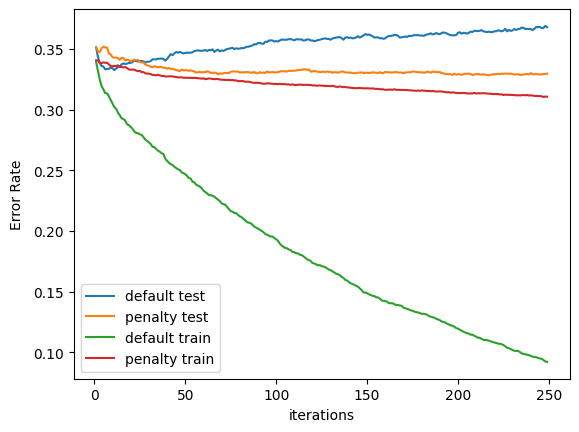

In [73]:
ax = results.plot(x='iterations', y='default test')     # Plot the validation error rate for the default model against iterations (trees)
results.plot(x='iterations', y='penalty test', ax=ax)   # Add the validation error rate for the penalized model to the same plot
results.plot(x='iterations', y='default train', ax=ax)  # Add the training error rate for the default model to the same plot
results.plot(x='iterations', y='penalty train', ax=ax)  # Add the training error rate for the penalized model to the same plot

# Y-axis legend
ax.annotate('Error Rate', xy=(-0.1, 0.5), xycoords='axes fraction', rotation=90, fontsize=10, ha='right', va='center')

plt.show()                                              # Display the plot with all four lines

#### Insights:
* The penalized model shows better generalization and is preferred over the default model.
* The ideal number of trees for the default model seems to be around 50 as the validation error starts to plateau afterward.
* The penalized model benefits more from additional iterations, and its validation error steadily decreases, highlighting the value of regularization.

## Hyperparameters and Cross-Validation

Cross-validation randomly splits up the data into K different
groups, also called folds. For each fold, a model is trained on the data not in the fold
and then evaluated on the data in the fold. This yields a measure of accuracy of the
model on out-of-sample data. The best set of hyperparameters is the one given by the
model with the lowest overall error as computed by averaging the errors from each of
the folds.

In [77]:
idx = np.random.choice(range(5),                            # Create an array of random integers (0-4) as indices for 5-fold cross-validation
                       size=len(X),                         # The size of the array matches the number of samples in X
                       replace=True)                        # Sampling with replacement
error = []                                                  # Initialize an empty list to store error results

# Loop through combinations of learning rate (eta) and max depth
for eta, max_depth in product([0.1, 0.5, 0.9], [3, 6, 9]):  # Iterate over all combinations of eta and max_depth

    # Create an XGBoost Classifier with specified parameters
    xgb = XGBClassifier(objective='binary:logistic',        # Use logistic objective for binary classification
                        n_estimators=250,                   # Use 250 trees
                        max_depth=max_depth,                # Set the maximum depth for the trees
                        learning_rate=eta,                  # Set the learning rate
                        eval_metric='error')                # Use error rate as evaluation metric
    
    cv_error = []                                           # Initialize an empty list to store cross-validation error for each fold
    
    for k in range(5):                                      # Loop through 5 folds
        fold_idx = idx == k                                 # Create boolean mask for the current fold
        train_X = X.loc[~fold_idx]; train_y = y[~fold_idx]  # Select training data by excluding the current fold
        valid_X = X.loc[fold_idx]; valid_y = y[fold_idx]    # Select validation data by including only the current fold

        xgb.fit(train_X, train_y)                           # Fit the XGBoost model on the training set
        
        pred = xgb.predict_proba(valid_X)[:, 1]             # Get predicted probabilities for the 'default' class
        
        cv_error.append(np.mean(abs(valid_y - pred) > 0.5)) # Calculate validation error (misclassification rate)
    
    # Store the results for the current parameter combination
    error.append({
        'eta': eta,                                         # Learning rate
        'max_depth': max_depth,                             # Maximum tree depth
        'avg_error': np.mean(cv_error)                      # Average cross-validation error across folds
    })
    
    print(error[-1])                                        # Print the error for the current eta and max_depth

{'eta': 0.1, 'max_depth': 3, 'avg_error': 0.3279754396967979}
{'eta': 0.1, 'max_depth': 6, 'avg_error': 0.3361856993484091}
{'eta': 0.1, 'max_depth': 9, 'avg_error': 0.3480255247471614}
{'eta': 0.5, 'max_depth': 3, 'avg_error': 0.3401133094842778}
{'eta': 0.5, 'max_depth': 6, 'avg_error': 0.3674329261269047}
{'eta': 0.5, 'max_depth': 9, 'avg_error': 0.3695460262206316}
{'eta': 0.9, 'max_depth': 3, 'avg_error': 0.35091096711636655}
{'eta': 0.9, 'max_depth': 6, 'avg_error': 0.3893218832913494}
{'eta': 0.9, 'max_depth': 9, 'avg_error': 0.3809813080390847}


In [78]:
errors = pd.DataFrame(error)
errors

,eta,max_depth,avg_error
0,0.1,3,0.327975
1,0.1,6,0.336186
2,0.1,9,0.348026
3,0.5,3,0.340113
4,0.5,6,0.367433
5,0.5,9,0.369546
6,0.9,3,0.350911
7,0.9,6,0.389322
8,0.9,9,0.380981


In [79]:
print(errors.pivot_table(index='eta', columns='max_depth', values='avg_error') * 100)

max_depth          3          6          9
eta                                       
0.1        32.797544  33.618570  34.802552
0.5        34.011331  36.743293  36.954603
0.9        35.091097  38.932188  38.098131


In [80]:
# Find the row with the minimum avg_error
min_error_row = errors.loc[errors['avg_error'].idxmin()]  

print("Best model performance:")
min_error_row

Best model performance:


eta          0.100000
max_depth    3.000000
avg_error    0.327975
Name: 0, dtype: float64